<a href="https://colab.research.google.com/github/thuongvan23/XAI-LandCover/blob/nhanLD/EfficientNet_satellite_frozen.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
import tifffile as tiff
import numpy as np

# Đường dẫn đến ảnh
img_path = "/kaggle/input/eurosat-dataset/EuroSATallBands/AnnualCrop/AnnualCrop_1.tif"

# Đọc ảnh
img = tiff.imread(img_path)

# In shape và giá trị pixel đầu tiên
print("Shape của ảnh:", img.shape)
print("Pixel đầu tiên:", img[0, 0])

Shape của ảnh: (64, 64, 13)
Pixel đầu tiên: [1420 1291 1291 1600 1680 1841 2045 2016  546   13 3083 2325 2319]


In [ ]:
# Chuẩn hóa giá trị pixel trong dải từ 0 đến 1
img_normalized = img / np.max(img)

print(np.max(img))

# Kiểm tra pixel sau khi chuẩn hóa
print("Pixel đầu tiên (sau khi chuẩn hóa):", img_normalized[0, 0])

3490
Pixel đầu tiên (sau khi chuẩn hóa): [0.40687679 0.36991404 0.36991404 0.45845272 0.48137536 0.52750716
 0.58595989 0.57765043 0.15644699 0.00372493 0.88338109 0.66618911
 0.66446991]


In [ ]:
import os

root_dir = "/content/eurosat_data/EuroSATallBands"

for root, dirs, files in os.walk(root_dir):
    level = root.replace(root_dir, '').count(os.sep)
    indent = ' ' * 2 * level
    print(f"{indent}{os.path.basename(root)}/")
    subindent = ' ' * 2 * (level + 1)
    for f in files[:5]:
        print(f"{subindent}{f}")

In [ ]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Tạo transform
train_transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, p=0.5),
    A.Normalize(mean=0.0, std=1.0, max_pixel_value=1.0),
    ToTensorV2(transpose_mask=True),
])

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.7 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [ ]:
pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 72.6 MB/s eta 0:00:00:00:0100:01
Note: you may need to restart the kernel to use updated packages.


In [ ]:
pip install efficientnet_pytorch

  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet_pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16424 sha256=758f49118874a9d1e4899ae677dbdea17fc29027c66cffcbc792a1dda00af432
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
Successfully built efficientnet_pytorch
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import pandas as pd
import os
import torch
from torch.utils.data import Dataset
import rasterio
import numpy as np
from efficientnet_pytorch import EfficientNet

class EuroSATCSV(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.data = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
      row = self.data.iloc[idx]
      img_path = os.path.join(self.root_dir, row['Filename'])
      label = int(row['Label'])

      with rasterio.open(img_path) as src:
          img = src.read().astype(np.float32)  # (13, 64, 64)
          img = img / 10000.0
          img = np.transpose(img, (1, 2, 0))  # (H, W, C) cho albumentations

      if self.transform:
          img = self.transform(image=img)["image"]  # vẫn là (H, W, C)

      img = np.transpose(img, (2, 0, 1))  # 🔁 Chuyển về (C, H, W) cho PyTorch
      img = torch.tensor(img, dtype=torch.float32)

      return img, label

In [ ]:
base_path = "/kaggle/input/eurosat-dataset/EuroSATallBands"

train_dataset = EuroSATCSV(
    csv_file=os.path.join(base_path, "train.csv"),
    root_dir=base_path,
)

val_dataset = EuroSATCSV(
    csv_file=os.path.join(base_path, "validation.csv"),
    root_dir=base_path,
)

test_dataset = EuroSATCSV(
    csv_file=os.path.join(base_path, "test.csv"),
    root_dir=base_path,
)

In [ ]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

In [ ]:
import torch.nn as nn
from efficientnet_pytorch import EfficientNet

In [ ]:
import torch
import torch.nn as nn
from efficientnet_pytorch import EfficientNet
from torch.optim.lr_scheduler import ReduceLROnPlateau

class EfficientNetSatelliteFrozen(nn.Module):
    def __init__(self, num_classes=10):
        super(EfficientNetSatelliteFrozen, self).__init__()
        # Load EfficientNet-b0 từ đầu (không pretrained)
        self.backbone = EfficientNet.from_name('efficientnet-b0')

        # Thay đổi layer đầu vào để nhận 13 kênh
        out_channels = self.backbone._conv_stem.out_channels
        self.backbone._conv_stem = nn.Conv2d(13, out_channels, kernel_size=3, stride=2, padding=1, bias=False)

        # Đóng băng toàn bộ backbone
        for param in self.backbone.parameters():
            param.requires_grad = False

        # Giữ lại phần classification head (chỉ phần này sẽ học)
        in_features = self.backbone._fc.in_features
        self.backbone._fc = nn.Linear(in_features, num_classes)

    def forward(self, x):
        return self.backbone(x)

In [ ]:
class EarlyStopping:
    def __init__(self, patience=7, delta=0.001):
        self.patience = patience
        self.delta = delta
        self.counter = 0
        self.best_loss = float('inf')
        self.early_stop = False

    def __call__(self, val_loss):
        if val_loss < self.best_loss - self.delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

In [ ]:
#5. TRAINING & EVALUATION LOOP
def train_one_epoch(model, dataloader, optimizer, criterion):
    model.train()
    total_loss, correct, total = 0, 0, 0
    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)
    return total_loss / total, correct / total

def evaluate(model, dataloader, criterion):
    model.eval()
    total_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)
    return total_loss / total, correct / total

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load mô hình EfficientNet từ đầu, frozen toàn bộ trừ phần fc
model = EfficientNetSatelliteFrozen(num_classes=10).to(device)

# Chỉ train phần classification head (_fc)
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)
criterion = nn.CrossEntropyLoss()

# Không cần `unfreeze_epoch` vì bạn freeze hoàn toàn
def train_model(model, train_loader, val_loader, optimizer, criterion, epochs=50):
    early_stopping = EarlyStopping(patience=5, delta=0.001)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

    for epoch in range(epochs):
        train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion)
        val_loss, val_acc = evaluate(model, val_loader, criterion)
        scheduler.step(val_loss)
        early_stopping(val_loss)

        print(f"Epoch {epoch+1}/{epochs}")
        print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
        print(f"  Val   Loss: {val_loss:.4f} | Val   Acc: {val_acc:.4f}")
        print(f"  Learning Rate: {optimizer.param_groups[0]['lr']:.6f}")

        if early_stopping.early_stop:
            print("Early stopping triggered.")
            break

# Gọi huấn luyện
train_model(model, train_loader, val_loader, optimizer, criterion, epochs=50)

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/50
  Train Loss: 1.9815 | Train Acc: 0.3112
  Val   Loss: 2.3642 | Val   Acc: 0.1736
  Learning Rate: 0.001000
Epoch 2/50
  Train Loss: 1.8677 | Train Acc: 0.3561
  Val   Loss: 1.8778 | Val   Acc: 0.3709
  Learning Rate: 0.001000
Epoch 3/50
  Train Loss: 1.8297 | Train Acc: 0.3635
  Val   Loss: 1.8989 | Val   Acc: 0.3524
  Learning Rate: 0.001000
Epoch 4/50
  Train Loss: 1.8243 | Train Acc: 0.3647
  Val   Loss: 1.8817 | Val   Acc: 0.3459
  Learning Rate: 0.001000
Epoch 5/50
  Train Loss: 1.8099 | Train Acc: 0.3710
  Val   Loss: 1.8387 | Val   Acc: 0.3941
  Learning Rate: 0.001000
Epoch 6/50
  Train Loss: 1.7950 | Train Acc: 0.3770
  Val   Loss: 1.8372 | Val   Acc: 0.3791
  Learning Rate: 0.001000
Epoch 7/50
  Train Loss: 1.8116 | Train Acc: 0.3743
  Val   Loss: 1.8282 | Val   Acc: 0.4013
  Learning Rate: 0.001000
Epoch 8/50
  Train Loss: 1.8035 | Train Acc: 0.3785
  Val   Loss: 1.7772 | Val   Acc: 0.3890
  Learning Rate: 0.001000
Epoch 9/50
  Train Loss: 1.8081 | Train Acc: 0.3

In [ ]:
test_loss, test_acc = evaluate(model, test_loader, criterion)
print(f"Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.4f}")

Test Loss: 1.7847 | Test Acc: 0.3842


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
import torch

In [ ]:
def visualize_predictions(model, dataloader, class_names, device, num_images=20):
    model.eval()
    images_shown = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for i in range(inputs.size(0)):
                if images_shown >= num_images:
                    return

                img = inputs[i].cpu().numpy()

                # Chọn 3 bands RGB (B4, B3, B2)
                rgb = img[[3, 2, 1], :, :]
                rgb = np.clip(rgb, 0, 1)

                plt.figure(figsize=(2.5, 2.5))
                plt.imshow(np.transpose(rgb, (1, 2, 0)))
                plt.title(f"Pred: {class_names[preds[i]]}\nTrue: {class_names[labels[i]]}")
                plt.axis('off')
                plt.show()

                images_shown += 1


In [ ]:
def plot_confusion_matrix(model, dataloader, class_names, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)

    fig, ax = plt.subplots(figsize=(8, 8))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(ax=ax, cmap="Blues", xticks_rotation=45)
    plt.title("Confusion Matrix")
    plt.grid(False)
    plt.show()


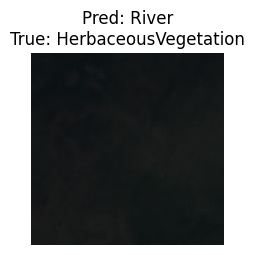

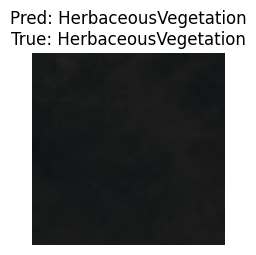

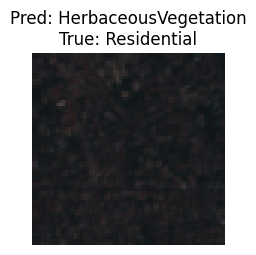

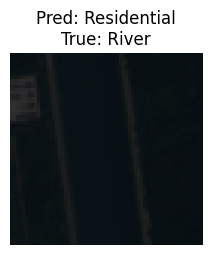

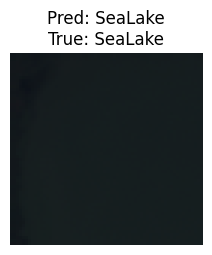

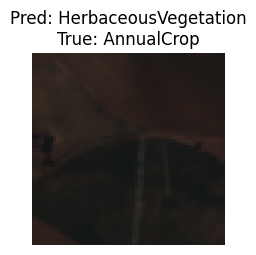

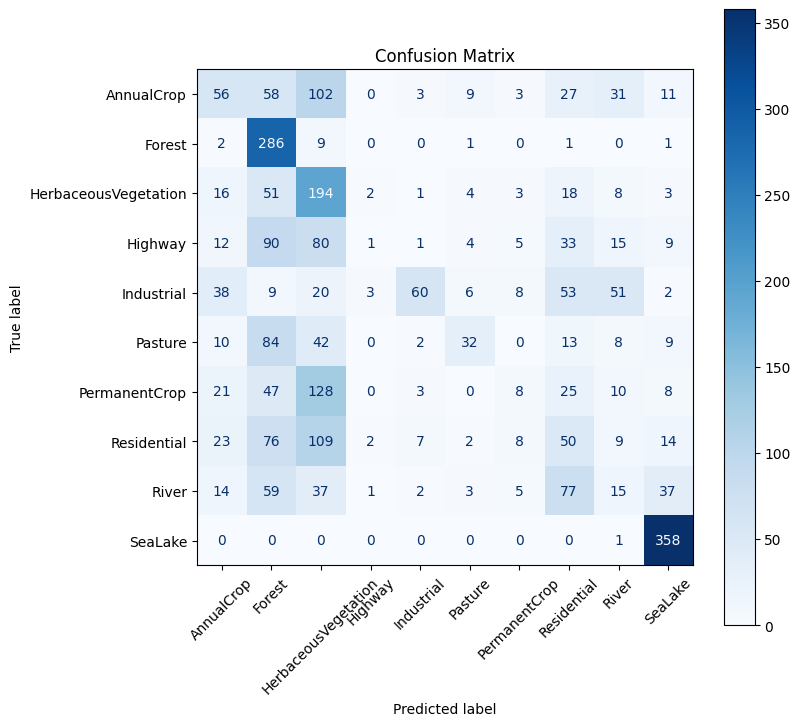

In [ ]:
# Tên lớp EuroSAT (10 lớp)
class_names = ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway',
               'Industrial', 'Pasture', 'PermanentCrop', 'Residential',
               'River', 'SeaLake']

# Vẽ ảnh dự đoán
visualize_predictions(model, test_loader, class_names, device, num_images=6)

# Vẽ confusion matrix
plot_confusion_matrix(model, test_loader, class_names, device)